<a href="https://colab.research.google.com/github/Ai-deen/DS605-Sign-Lanaguage-Translation-Project/blob/main/DS605_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install transformers datasets

In [ ]:
!pip install sentencepiece

In [ ]:
# from transformers import MarianMTModel, MarianTokenizer

src_text = [
    ">>de<< my friend is an idiot",
    ">>de<< why am i here",
    ">>de<< i hate my life",
]

model_name = "Helsinki-NLP/opus-mt-en-de"
tokenizer = MarianTokenizer.from_pretrained(model_name)
print(tokenizer.supported_language_codes)

model = MarianMTModel.from_pretrained(model_name)
translated = model.generate(**tokenizer(src_text, return_tensors="pt", padding=True))
[tokenizer.decode(t, skip_special_tokens=True) for t in translated]

[]


['Mein Freund ist ein Idiot', 'Warum bin ich hier?', 'Ich hasse mein Leben']

#PROJECT

In [ ]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('T-Systems-onsite/cross-en-de-roberta-sentence-transformer')

In [ ]:
!pip install "tensorflow-text>=2.11"
!pip install einops

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 18.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 1.7 MB/s eta 0:00:00


In [ ]:
import numpy as np

import typing
from typing import Any, Tuple

import einops
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import tensorflow as tf
import tensorflow_text as tf_text

In [ ]:
from pathlib import Path

def load_data(file_path):
    # Use the Path class to create a Path object
    path = Path(file_path)

    # Open the file and read its content
    with path.open(mode='r', encoding='utf-8') as file:
        file_content = file.read()

    lines = file_content.splitlines()
    lines = np.array([i for i in lines])

    return lines

# Provide the correct file path
context = load_data("/content/phoenix_sentences_train_lower.txt")
target = load_data("/content/phoenix_glosses_train_lower.txt")

In [ ]:
context[7]

'am freitag kann es in der osthälfte teilweise länger und kräftig regnen vorsicht hochwassergefahr'

In [ ]:
target[7]

'freitag ost koennen regen stark regen vorsicht ueberschwemmung koennen'

In [ ]:
BUFFER_SIZE = len(context)
BATCH_SIZE = 64

is_train = np.random.uniform(size=(len(target),)) < 0.8

train = (
    tf.data.Dataset
    .from_tensor_slices((context[is_train], target[is_train]))
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE))
val = (
    tf.data.Dataset
    .from_tensor_slices((context[~is_train], target[~is_train]))
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE))

In [ ]:
for example_context_strings, example_target_strings in train.take(1):
  print(example_context_strings[:5])
  print()
  print(example_target_strings[:5])
  break

tf.Tensor(
[b'heute nacht klart es im norden zum teil auf und dann geht es wieder so richtig ab in die tiefk\xc3\xbchltruhe kann man fast sagen bis minus achtzehn grad'
 b'und so geht es dann auch \xc3\xbcbers wochenende sonne w\xc3\xa4rme es bleibt trocken'
 b'wir haben ein sturmtief \xc3\xbcber d\xc3\xa4nemark das jetzt weiterzieht richtung s\xc3\xbcdschweden viel regen f\xc3\xa4llt dabei heute nacht noch an den k\xc3\xbcsten'
 b'vorsicht wegen gl\xc3\xa4tte'
 b'schwacher richtung norden teilweise m\xc3\xa4\xc3\x9figer an der k\xc3\xbcste auch frischer wind aus s\xc3\xbcdlichen richtungen'], shape=(5,), dtype=string)

tf.Tensor(
[b'heute nacht nord region klar himmel enorm kalt sagen wie gefrieren schrank minus achtzehn grad'
 b'ix samstag sonntag selbe sonne warm bleiben trocken'
 b'daenemark sturm tief schweden sued ix sturm kueste regen'
 b'vorsicht glatt'
 b'ix wehen schwach maessig ix kueste auch frisch auch wehen'], shape=(5,), dtype=string)


#### Standardization

In [ ]:
def tf_lower_and_split_punct(text):
  # Split accented characters.
  text = tf_text.normalize_utf8(text, 'NFKD')
  text = tf.strings.lower(text)
  # Keep space, a to z, and select punctuation.
  text = tf.strings.regex_replace(text, '[^ a-z.?!,¿]', '')
  # Add spaces around punctuation.
  text = tf.strings.regex_replace(text, '[.?!,¿]', r' \0 ')
  # Strip whitespace.
  text = tf.strings.strip(text)

  text = tf.strings.join(['[START]', text, '[END]'], separator=' ')
  return text

In [ ]:
max_vocab_size = 5000

context_text_processor = tf.keras.layers.TextVectorization(
    standardize=tf_lower_and_split_punct,
    max_tokens=max_vocab_size,
    ragged=True)

In [ ]:
context_text_processor.adapt(train.map(lambda context, target: context))

# Here are the first 10 words from the vocabulary:
context_text_processor.get_vocabulary()[:10]

['', '[UNK]', '[START]', '[END]', 'und', 'im', 'es', 'der', 'am', 'in']

In [ ]:
target_text_processor = tf.keras.layers.TextVectorization(
    standardize=tf_lower_and_split_punct,
    max_tokens=max_vocab_size,
    ragged=True)

target_text_processor.adapt(train.map(lambda context, target: target))
target_text_processor.get_vocabulary()[:10]

['',
 '[UNK]',
 '[START]',
 '[END]',
 'regen',
 'region',
 'ix',
 'kommen',
 'morgen',
 'nord']

In [ ]:

example_tokens = context_text_processor(example_context_strings)
example_tokens[:3, :]

<tf.RaggedTensor [[2, 20, 16, 332, 6, 5, 26, 50, 72, 43, 4, 36, 211, 6, 41, 93, 417, 101, 9,
  10, 1837, 92, 451, 464, 779, 13, 68, 239, 12, 3]                         ,
 [2, 4, 93, 211, 6, 36, 11, 1801, 175, 24, 296, 6, 64, 83, 3],
 [2, 94, 125, 23, 550, 45, 804, 30, 210, 1709, 70, 1408, 111, 19, 105, 79,
  20, 16, 18, 17, 14, 115, 3]                                             ]>

In [ ]:
context_vocab = np.array(context_text_processor.get_vocabulary())
tokens = context_vocab[example_tokens[0].numpy()]
' '.join(tokens)

'[START] heute nacht klart es im norden zum teil auf und dann geht es wieder so richtig ab in die tiefkuhltruhe kann man fast sagen bis minus achtzehn grad [END]'

Text(0.5, 1.0, 'Mask')

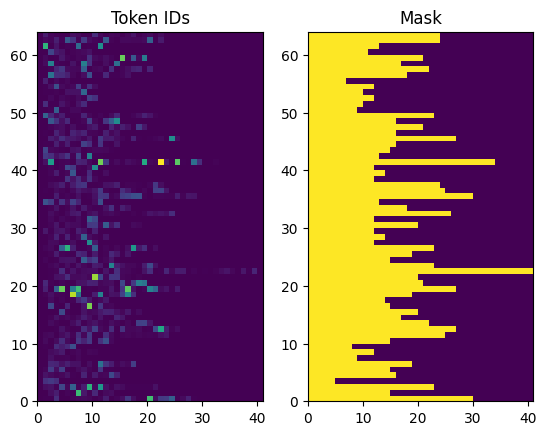

In [ ]:
plt.subplot(1, 2, 1)
plt.pcolormesh(example_tokens.to_tensor())
plt.title('Token IDs')

plt.subplot(1, 2, 2)
plt.pcolormesh(example_tokens.to_tensor() != 0)
plt.title('Mask')

In [ ]:
def process_text(context, target):
  context = context_text_processor(context).to_tensor()
  target = target_text_processor(target)
  targ_in = target[:,:-1].to_tensor()
  targ_out = target[:,1:].to_tensor()
  return (context, targ_in), targ_out


train_ds = train.map(process_text, tf.data.AUTOTUNE)
val_ds = val.map(process_text, tf.data.AUTOTUNE)

In [ ]:
for (ex_context_tok, ex_tar_in), ex_tar_out in train_ds.take(1):
  print(ex_context_tok[0, :10].numpy())
  print()
  print(ex_tar_in[0, :10].numpy())
  print(ex_tar_out[0, :10].numpy())

[  2   4 419 216 163  42  27   6  96  41]

[  2  26 155 160 119 756  67   0   0   0]
[ 26 155 160 119 756  67   3   0   0   0]


In [ ]:
UNITS = 256

In [ ]:
#@title
class ShapeChecker():
  def __init__(self):
    # Keep a cache of every axis-name seen
    self.shapes = {}

  def __call__(self, tensor, names, broadcast=False):
    if not tf.executing_eagerly():
      return

    parsed = einops.parse_shape(tensor, names)

    for name, new_dim in parsed.items():
      old_dim = self.shapes.get(name, None)

      if (broadcast and new_dim == 1):
        continue

      if old_dim is None:
        # If the axis name is new, add its length to the cache.
        self.shapes[name] = new_dim
        continue

      if new_dim != old_dim:
        raise ValueError(f"Shape mismatch for dimension: '{name}'\n"
                         f"    found: {new_dim}\n"
                         f"    expected: {old_dim}\n")

In [ ]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, text_processor, units):
    super(Encoder, self).__init__()
    self.text_processor = text_processor
    self.vocab_size = text_processor.vocabulary_size()
    self.units = units

    # The embedding layer converts tokens to vectors
    self.embedding = tf.keras.layers.Embedding(self.vocab_size, units,
                                               mask_zero=True)

    # The RNN layer processes those vectors sequentially.
    self.rnn = tf.keras.layers.Bidirectional(
        merge_mode='sum',
        layer=tf.keras.layers.GRU(units,
                            # Return the sequence and state
                            return_sequences=True,
                            recurrent_initializer='glorot_uniform'))

  def call(self, x):
    shape_checker = ShapeChecker()
    shape_checker(x, 'batch s')

    # 2. The embedding layer looks up the embedding vector for each token.
    x = self.embedding(x)
    shape_checker(x, 'batch s units')

    # 3. The GRU processes the sequence of embeddings.
    x = self.rnn(x)
    shape_checker(x, 'batch s units')

    # 4. Returns the new sequence of embeddings.
    return x

  def convert_input(self, texts):
    texts = tf.convert_to_tensor(texts)
    if len(texts.shape) == 0:
      texts = tf.convert_to_tensor(texts)[tf.newaxis]
    context = self.text_processor(texts).to_tensor()
    context = self(context)
    return context

In [ ]:
# Encode the input sequence.
encoder = Encoder(context_text_processor, UNITS)
ex_context = encoder(ex_context_tok)

print(f'Context tokens, shape (batch, s): {ex_context_tok.shape}')
print(f'Encoder output, shape (batch, s, units): {ex_context.shape}')

Context tokens, shape (batch, s): (64, 30)
Encoder output, shape (batch, s, units): (64, 30, 256)


In [ ]:
class CrossAttention(tf.keras.layers.Layer):
  def __init__(self, units, **kwargs):
    super().__init__()
    self.mha = tf.keras.layers.MultiHeadAttention(key_dim=units, num_heads=1, **kwargs)
    self.layernorm = tf.keras.layers.LayerNormalization()
    self.add = tf.keras.layers.Add()

  def call(self, x, context):
    shape_checker = ShapeChecker()

    shape_checker(x, 'batch t units')
    shape_checker(context, 'batch s units')

    attn_output, attn_scores = self.mha(
        query=x,
        value=context,
        return_attention_scores=True)

    shape_checker(x, 'batch t units')
    shape_checker(attn_scores, 'batch heads t s')

    # Cache the attention scores for plotting later.
    attn_scores = tf.reduce_mean(attn_scores, axis=1)
    shape_checker(attn_scores, 'batch t s')
    self.last_attention_weights = attn_scores

    x = self.add([x, attn_output])
    x = self.layernorm(x)

    return x

In [ ]:
attention_layer = CrossAttention(UNITS)

# Attend to the encoded tokens
embed = tf.keras.layers.Embedding(target_text_processor.vocabulary_size(),
                                  output_dim=UNITS, mask_zero=True)
ex_tar_embed = embed(ex_tar_in)

result = attention_layer(ex_tar_embed, ex_context)

print(f'Context sequence, shape (batch, s, units): {ex_context.shape}')
print(f'Target sequence, shape (batch, t, units): {ex_tar_embed.shape}')
print(f'Attention result, shape (batch, t, units): {result.shape}')
print(f'Attention weights, shape (batch, t, s):    {attention_layer.last_attention_weights.shape}')

Context sequence, shape (batch, s, units): (64, 30, 256)
Target sequence, shape (batch, t, units): (64, 13, 256)
Attention result, shape (batch, t, units): (64, 13, 256)
Attention weights, shape (batch, t, s):    (64, 13, 30)


In [ ]:
attention_layer.last_attention_weights[0].numpy().sum(axis=-1)

array([0.9999999 , 0.9999999 , 1.        , 1.        , 1.        ,
       0.99999994, 1.        , 0.99999976, 0.99999976, 0.99999976,
       0.99999976, 0.99999976, 0.99999976], dtype=float32)

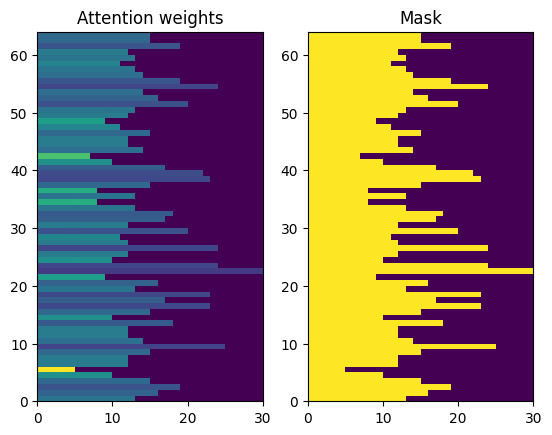

In [ ]:
attention_weights = attention_layer.last_attention_weights
mask=(ex_context_tok != 0).numpy()

plt.subplot(1, 2, 1)
plt.pcolormesh(mask*attention_weights[:, 0, :])
plt.title('Attention weights')

plt.subplot(1, 2, 2)
plt.pcolormesh(mask)
plt.title('Mask');


In [ ]:
class Decoder(tf.keras.layers.Layer):
  @classmethod
  def add_method(cls, fun):
    setattr(cls, fun.__name__, fun)
    return fun

  def __init__(self, text_processor, units):
    super(Decoder, self).__init__()
    self.text_processor = text_processor
    self.vocab_size = text_processor.vocabulary_size()
    self.word_to_id = tf.keras.layers.StringLookup(
        vocabulary=text_processor.get_vocabulary(),
        mask_token='', oov_token='[UNK]')
    self.id_to_word = tf.keras.layers.StringLookup(
        vocabulary=text_processor.get_vocabulary(),
        mask_token='', oov_token='[UNK]',
        invert=True)
    self.start_token = self.word_to_id('[START]')
    self.end_token = self.word_to_id('[END]')

    self.units = units


    # 1. The embedding layer converts token IDs to vectors
    self.embedding = tf.keras.layers.Embedding(self.vocab_size,
                                               units, mask_zero=True)

    # 2. The RNN keeps track of what's been generated so far.
    self.rnn = tf.keras.layers.GRU(units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')

    # 3. The RNN output will be the query for the attention layer.
    self.attention = CrossAttention(units)

    # 4. This fully connected layer produces the logits for each
    # output token.
    self.output_layer = tf.keras.layers.Dense(self.vocab_size)

In [ ]:
@Decoder.add_method
def call(self,
         context, x,
         state=None,
         return_state=False):
  shape_checker = ShapeChecker()
  shape_checker(x, 'batch t')
  shape_checker(context, 'batch s units')

  # 1. Lookup the embeddings
  x = self.embedding(x)
  shape_checker(x, 'batch t units')

  # 2. Process the target sequence.
  x, state = self.rnn(x, initial_state=state)
  shape_checker(x, 'batch t units')

  # 3. Use the RNN output as the query for the attention over the context.
  x = self.attention(x, context)
  self.last_attention_weights = self.attention.last_attention_weights
  shape_checker(x, 'batch t units')
  shape_checker(self.last_attention_weights, 'batch t s')

  # Step 4. Generate logit predictions for the next token.
  logits = self.output_layer(x)
  shape_checker(logits, 'batch t target_vocab_size')

  if return_state:
    return logits, state
  else:
    return logits

In [ ]:
decoder = Decoder(target_text_processor, UNITS)

In [ ]:
logits = decoder(ex_context, ex_tar_in)

print(f'encoder output shape: (batch, s, units) {ex_context.shape}')
print(f'input target tokens shape: (batch, t) {ex_tar_in.shape}')
print(f'logits shape shape: (batch, target_vocabulary_size) {logits.shape}')

encoder output shape: (batch, s, units) (64, 30, 256)
input target tokens shape: (batch, t) (64, 13)
logits shape shape: (batch, target_vocabulary_size) (64, 13, 1011)


In [ ]:
@Decoder.add_method
def get_initial_state(self, context):
  batch_size = tf.shape(context)[0]
  start_tokens = tf.fill([batch_size, 1], self.start_token)
  done = tf.zeros([batch_size, 1], dtype=tf.bool)
  embedded = self.embedding(start_tokens)
  return start_tokens, done, self.rnn.get_initial_state(embedded)[0]

In [ ]:
@Decoder.add_method
def tokens_to_text(self, tokens):
  words = self.id_to_word(tokens)
  result = tf.strings.reduce_join(words, axis=-1, separator=' ')
  result = tf.strings.regex_replace(result, '^ *\[START\] *', '')
  result = tf.strings.regex_replace(result, ' *\[END\] *$', '')
  return result

In [ ]:
@Decoder.add_method
def get_next_token(self, context, next_token, done, state, temperature = 0.0):
  logits, state = self(
    context, next_token,
    state = state,
    return_state=True)

  if temperature == 0.0:
    next_token = tf.argmax(logits, axis=-1)
  else:
    logits = logits[:, -1, :]/temperature
    next_token = tf.random.categorical(logits, num_samples=1)

  # If a sequence produces an `end_token`, set it `done`
  done = done | (next_token == self.end_token)
  # Once a sequence is done it only produces 0-padding.
  next_token = tf.where(done, tf.constant(0, dtype=tf.int64), next_token)

  return next_token, done, state

In [ ]:
# Setup the loop variables.
next_token, done, state = decoder.get_initial_state(ex_context)
tokens = []

for n in range(10):
  # Run one step.
  next_token, done, state = decoder.get_next_token(
      ex_context, next_token, done, state, temperature=1.0)
  # Add the token to the output.
  tokens.append(next_token)

# Stack all the tokens together.
tokens = tf.concat(tokens, axis=-1) # (batch, t)

# Convert the tokens back to a a string
result = decoder.tokens_to_text(tokens)
result[:3].numpy()

array([b'besonders weiter u juni wieaussehen negnochnicht dann bedingungen spueren mecklenburgvorpommern',
       b'tja vorher inbestimmtzeit nah dann nordrheinwestfalen negschoen fuenfuhr uebermorgen orkan',
       b'ski wirbelsturm streifen stellenweise lang ausnahme is abjetzt ferz paar'],
      dtype=object)

In [ ]:
class Translator(tf.keras.Model):
  @classmethod
  def add_method(cls, fun):
    setattr(cls, fun.__name__, fun)
    return fun

  def __init__(self, units,
               context_text_processor,
               target_text_processor):
    super().__init__()
    # Build the encoder and decoder
    encoder = Encoder(context_text_processor, units)
    decoder = Decoder(target_text_processor, units)

    self.encoder = encoder
    self.decoder = decoder

  def call(self, inputs):
    context, x = inputs
    context = self.encoder(context)
    logits = self.decoder(context, x)

    #TODO(b/250038731): remove this
    try:
      # Delete the keras mask, so keras doesn't scale the loss+accuracy.
      del logits._keras_mask
    except AttributeError:
      pass

    return logits

In [ ]:
model = Translator(UNITS, context_text_processor, target_text_processor)

logits = model((ex_context_tok, ex_tar_in))

print(f'Context tokens, shape: (batch, s, units) {ex_context_tok.shape}')
print(f'Target tokens, shape: (batch, t) {ex_tar_in.shape}')
print(f'logits, shape: (batch, t, target_vocabulary_size) {logits.shape}')

Context tokens, shape: (batch, s, units) (64, 30)
Target tokens, shape: (batch, t) (64, 13)
logits, shape: (batch, t, target_vocabulary_size) (64, 13, 1011)


In [ ]:
def masked_loss(y_true, y_pred):
    # Calculate the loss for each item in the batch.
    loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction='none')
    loss = loss_fn(y_true, y_pred)

    # Mask off the losses on padding.
    mask = tf.cast(y_true != 0, loss.dtype)
    loss *= mask

    # Return the total.
    return tf.reduce_sum(loss)/tf.reduce_sum(mask)

In [ ]:
def masked_acc(y_true, y_pred):
    # Calculate the loss for each item in the batch.
    y_pred = tf.argmax(y_pred, axis=-1)
    y_pred = tf.cast(y_pred, y_true.dtype)

    match = tf.cast(y_true == y_pred, tf.float32)
    mask = tf.cast(y_true != 0, tf.float32)

    return tf.reduce_sum(match)/tf.reduce_sum(mask)

In [ ]:
model.compile(optimizer='adam',
              loss=masked_loss,
              metrics=[masked_acc, masked_loss])

In [ ]:
vocab_size = 1.0 * target_text_processor.vocabulary_size()

{"expected_loss": tf.math.log(vocab_size).numpy(),
 "expected_acc": 1/vocab_size}

{'expected_loss': 6.9186954, 'expected_acc': 0.0009891196834817012}

In [ ]:
model.evaluate(val_ds, steps=20, return_dict=True)

20/20 [==============================] - 40s 519ms/step - loss: 6.9319 - masked_acc: 8.2506e-04 - masked_loss: 6.9319


{'loss': 6.931892395019531,
 'masked_acc': 0.0008250626851804554,
 'masked_loss': 6.931892395019531}

##try 1

In [ ]:
history = model.fit(
    train_ds.repeat(),
    epochs=100,
    steps_per_epoch = 100,
    validation_data=val_ds,
    validation_steps = 20,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=3)])

Epoch 1/100
100/100 [==============================] - 105s 744ms/step - loss: 4.2361 - masked_acc: 0.2193 - masked_loss: 4.2286 - val_loss: 3.5027 - val_masked_acc: 0.3050 - val_masked_loss: 3.5027
Epoch 2/100
100/100 [==============================] - 79s 786ms/step - loss: 3.0229 - masked_acc: 0.3710 - masked_loss: 3.0213 - val_loss: 3.0767 - val_masked_acc: 0.3730 - val_masked_loss: 3.0767
Epoch 3/100
100/100 [==============================] - 78s 782ms/step - loss: 2.5199 - masked_acc: 0.4447 - masked_loss: 2.5183 - val_loss: 2.9162 - val_masked_acc: 0.4056 - val_masked_loss: 2.9162
Epoch 4/100
100/100 [==============================] - 77s 764ms/step - loss: 2.1560 - masked_acc: 0.4967 - masked_loss: 2.1571 - val_loss: 2.8399 - val_masked_acc: 0.4155 - val_masked_loss: 2.8399
Epoch 5/100
100/100 [==============================] - 77s 764ms/step - loss: 1.9094 - masked_acc: 0.5363 - masked_loss: 1.9106 - val_loss: 2.8482 - val_masked_acc: 0.4315 - val_masked_loss: 2.8482
Epoch 6/1

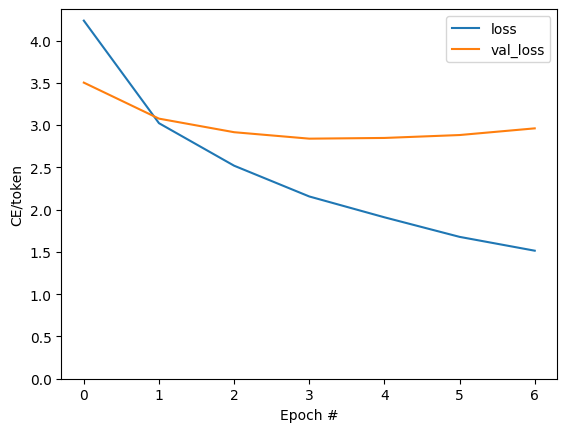

In [ ]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('CE/token')
plt.legend()

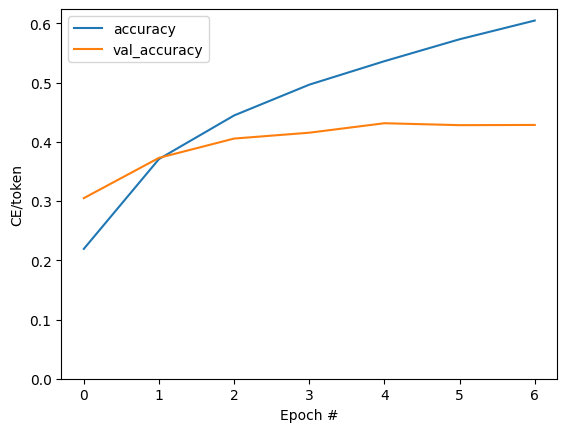

In [ ]:
plt.plot(history.history['masked_acc'], label='accuracy')
plt.plot(history.history['val_masked_acc'], label='val_accuracy')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('CE/token')
plt.legend()

In [ ]:
#@title
@Translator.add_method
def translate(self,
              texts, *,
              max_length=50,
              temperature=0.0):
  # Process the input texts
  context = self.encoder.convert_input(texts)
  batch_size = tf.shape(texts)[0]

  # Setup the loop inputs
  tokens = []
  attention_weights = []
  next_token, done, state = self.decoder.get_initial_state(context)

  for _ in range(max_length):
    # Generate the next token
    next_token, done, state = self.decoder.get_next_token(
        context, next_token, done,  state, temperature)

    # Collect the generated tokens
    tokens.append(next_token)
    attention_weights.append(self.decoder.last_attention_weights)

    if tf.executing_eagerly() and tf.reduce_all(done):
      break

  # Stack the lists of tokens and attention weights.
  tokens = tf.concat(tokens, axis=-1)   # t*[(batch 1)] -> (batch, t)
  self.last_attention_weights = tf.concat(attention_weights, axis=1)  # t*[(batch 1 s)] -> (batch, t s)

  result = self.decoder.tokens_to_text(tokens)
  return result

In [ ]:
result = model.translate(['am tag fünfzehn grad auf rügen und fünfundzwanzig grad am oberrhein'])
result[0].numpy().decode()

'tag fuenfzehn grad ruegen ix fuenf zwanzig grad '

In [ ]:
Input:
During the day fifteen degrees on Rügen and twenty-five degrees on the Upper Rhine
am tag fünfzehn grad auf rügen und fünfundzwanzig grad am oberrhein

Observed:
morgen fuenfzehn grad ruegen fuenf zwanzig grad
Tomorrow fifteen degrees ruegen five twenty

Actual:
tag fuenfzehn grad ruegen region fuenf zwanzig fluss
day fifteen degrees ruegen region five twenty river

In [ ]:
from nltk.translate.bleu_score import sentence_bleu

def calculate_bleu(reference, candidate):
    return sentence_bleu([reference], candidate)

reference = ["morgen", "fuenfzehn", "grad", "ruegen", "fuenf", "zwanzig", "grad"]
candidate = ["tag","fuenfzehn", "grad", "ruegen", "region", "fuenf", "zwanzig", "fluss"]
bleu_score = calculate_bleu(reference, candidate)
print("BLEU Score:", bleu_score)

BLEU Score: 5.614021910443866e-78


/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


##try 2

In [ ]:
model1 = Translator(UNITS, context_text_processor, target_text_processor)

logits = model1((ex_context_tok, ex_tar_in))

print(f'Context tokens, shape: (batch, s, units) {ex_context_tok.shape}')
print(f'Target tokens, shape: (batch, t) {ex_tar_in.shape}')
print(f'logits, shape: (batch, t, target_vocabulary_size) {logits.shape}')

Context tokens, shape: (batch, s, units) (64, 38)
Target tokens, shape: (batch, t) (64, 21)
logits, shape: (batch, t, target_vocabulary_size) (64, 21, 1006)


In [ ]:
model1.compile(optimizer='adam',
              loss=masked_loss,
              metrics=[masked_acc, masked_loss])

In [ ]:
history1 = model1.fit(
    train_ds.repeat(),
    epochs=100,
    steps_per_epoch = 100,
    validation_data=val_ds,
    validation_steps = 20,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=10)])

Epoch 1/100
100/100 [==============================] - 85s 699ms/step - loss: 4.2495 - masked_acc: 0.2187 - masked_loss: 4.2488 - val_loss: 3.5203 - val_masked_acc: 0.2948 - val_masked_loss: 3.5203
Epoch 2/100
100/100 [==============================] - 61s 613ms/step - loss: 3.0295 - masked_acc: 0.3697 - masked_loss: 3.0295 - val_loss: 3.0660 - val_masked_acc: 0.3801 - val_masked_loss: 3.0660
Epoch 3/100
100/100 [==============================] - 59s 592ms/step - loss: 2.5028 - masked_acc: 0.4457 - masked_loss: 2.5029 - val_loss: 2.8237 - val_masked_acc: 0.4238 - val_masked_loss: 2.8237
Epoch 4/100
100/100 [==============================] - 61s 610ms/step - loss: 2.1342 - masked_acc: 0.5046 - masked_loss: 2.1343 - val_loss: 2.7774 - val_masked_acc: 0.4328 - val_masked_loss: 2.7774
Epoch 5/100
100/100 [==============================] - 59s 592ms/step - loss: 1.8773 - masked_acc: 0.5422 - masked_loss: 1.8773 - val_loss: 2.8366 - val_masked_acc: 0.4283 - val_masked_loss: 2.8366
Epoch 6/10

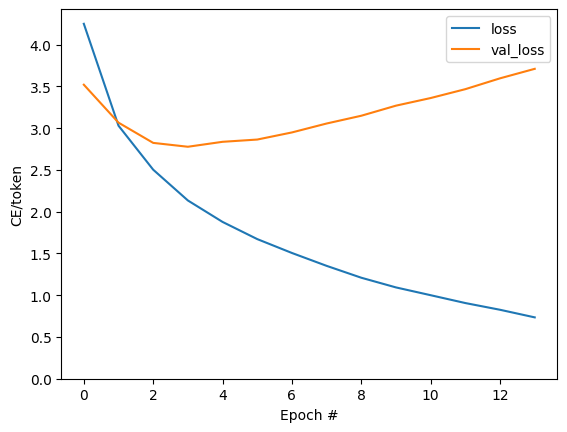

In [ ]:
plt.plot(history1.history['loss'], label='loss')
plt.plot(history1.history['val_loss'], label='val_loss')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('CE/token')
plt.legend()

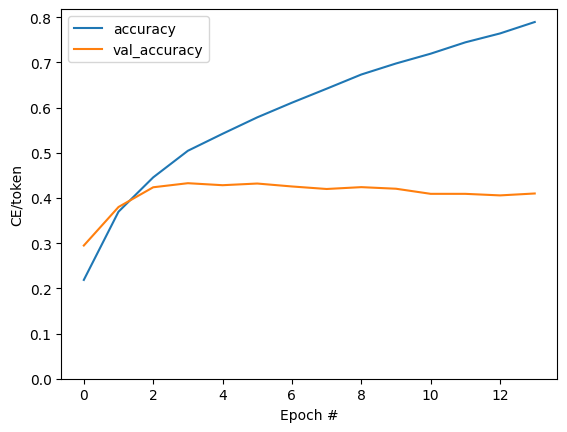

In [ ]:
plt.plot(history1.history['masked_acc'], label='accuracy')
plt.plot(history1.history['val_masked_acc'], label='val_accuracy')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('CE/token')
plt.legend()

In [ ]:
#@title
@Translator.add_method
def translate(self,
              texts, *,
              max_length=50,
              temperature=0.0):
  # Process the input texts
  context = self.encoder.convert_input(texts)
  batch_size = tf.shape(texts)[0]

  # Setup the loop inputs
  tokens = []
  attention_weights = []
  next_token, done, state = self.decoder.get_initial_state(context)

  for _ in range(max_length):
    # Generate the next token
    next_token, done, state = self.decoder.get_next_token(
        context, next_token, done,  state, temperature)

    # Collect the generated tokens
    tokens.append(next_token)
    attention_weights.append(self.decoder.last_attention_weights)

    if tf.executing_eagerly() and tf.reduce_all(done):
      break

  # Stack the lists of tokens and attention weights.
  tokens = tf.concat(tokens, axis=-1)   # t*[(batch 1)] -> (batch, t)
  self.last_attention_weights = tf.concat(attention_weights, axis=1)  # t*[(batch 1 s)] -> (batch, t s)

  result = self.decoder.tokens_to_text(tokens)
  return result

In [ ]:
result = model.translate(['am tag fünfzehn grad auf rügen und fünfundzwanzig grad am oberrhein'])
result[0].numpy().decode()

'morgen fuenfzehn grad ruegen fuenf zwanzig grad '

In [ ]:
Input:
During the day fifteen degrees on Rügen and twenty-five degrees on the Upper Rhine
am tag fünfzehn grad auf rügen und fünfundzwanzig grad am oberrhein

Observed:
model: morgen fuenfzehn grad ruegen fuenf zwanzig grad
model1: morgen fuenfzehn grad ruegen fuenf zwanzig grad
Tomorrow fifteen degrees ruegen five twenty

Actual:
tag fuenfzehn grad ruegen region fuenf zwanzig fluss
day fifteen degrees ruegen region five twenty river

In [ ]:
from nltk.translate.bleu_score import sentence_bleu

def calculate_bleu(reference, candidate):
    return sentence_bleu([reference], candidate)

reference = ["morgen", "fuenfzehn", "grad", "ruegen", "fuenf", "zwanzig", "grad"]
candidate = ["tag","fuenfzehn", "grad", "ruegen", "region", "fuenf", "zwanzig", "fluss"]
bleu_score = calculate_bleu(reference, candidate)
print("BLEU Score:", bleu_score)

BLEU Score: 5.614021910443866e-78


/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


In [ ]:
#@title
@Translator.add_method
def plot_attention(self, text, **kwargs):
  assert isinstance(text, str)
  output = self.translate([text], **kwargs)
  output = output[0].numpy().decode()

  attention = self.last_attention_weights[0]

  context = tf_lower_and_split_punct(text)
  context = context.numpy().decode().split()

  output = tf_lower_and_split_punct(output)
  output = output.numpy().decode().split()[1:]

  fig = plt.figure(figsize=(10, 10))
  ax = fig.add_subplot(1, 1, 1)

  ax.matshow(attention, cmap='viridis', vmin=0.0)

  fontdict = {'fontsize': 14}

  ax.set_xticklabels([''] + context, fontdict=fontdict, rotation=90)
  ax.set_yticklabels([''] + output, fontdict=fontdict)

  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

  ax.set_xlabel('Input text')
  ax.set_ylabel('Output text')

<ipython-input-74-93059eaa9bfc>:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + context, fontdict=fontdict, rotation=90)
<ipython-input-74-93059eaa9bfc>:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + output, fontdict=fontdict)


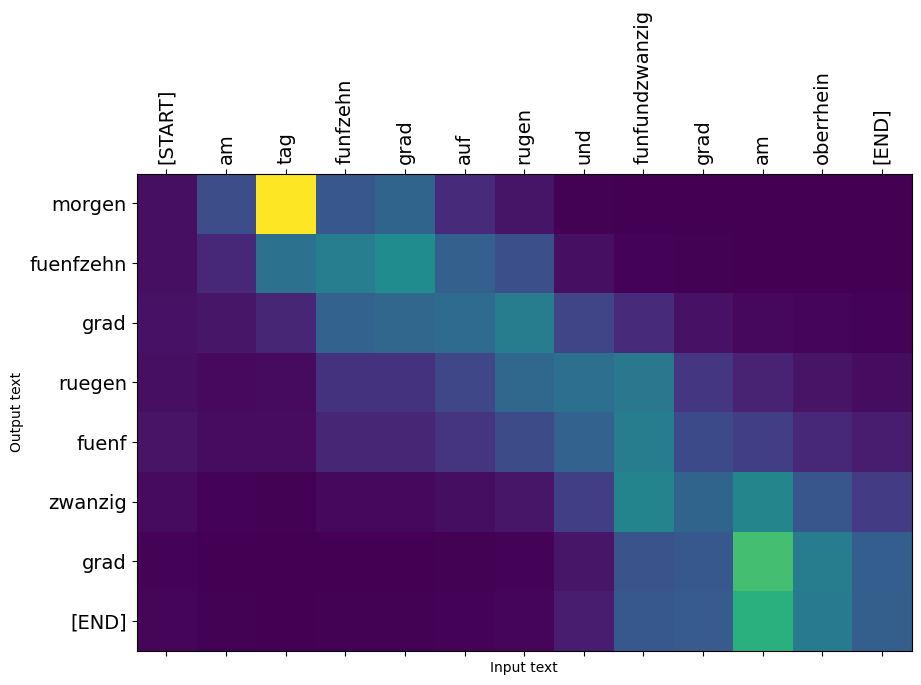

In [ ]:
model.plot_attention('am tag fünfzehn grad auf rügen und fünfundzwanzig grad am oberrhein') # Are you still home

In [ ]:
result = model.translate(['und nun die wettervorhersage für morgen dienstag den neunundzwanzigsten november'])
result[0].numpy().decode()

'jetzt wetter morgen dienstag neun zwanzig november '

<ipython-input-74-93059eaa9bfc>:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + context, fontdict=fontdict, rotation=90)
<ipython-input-74-93059eaa9bfc>:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + output, fontdict=fontdict)


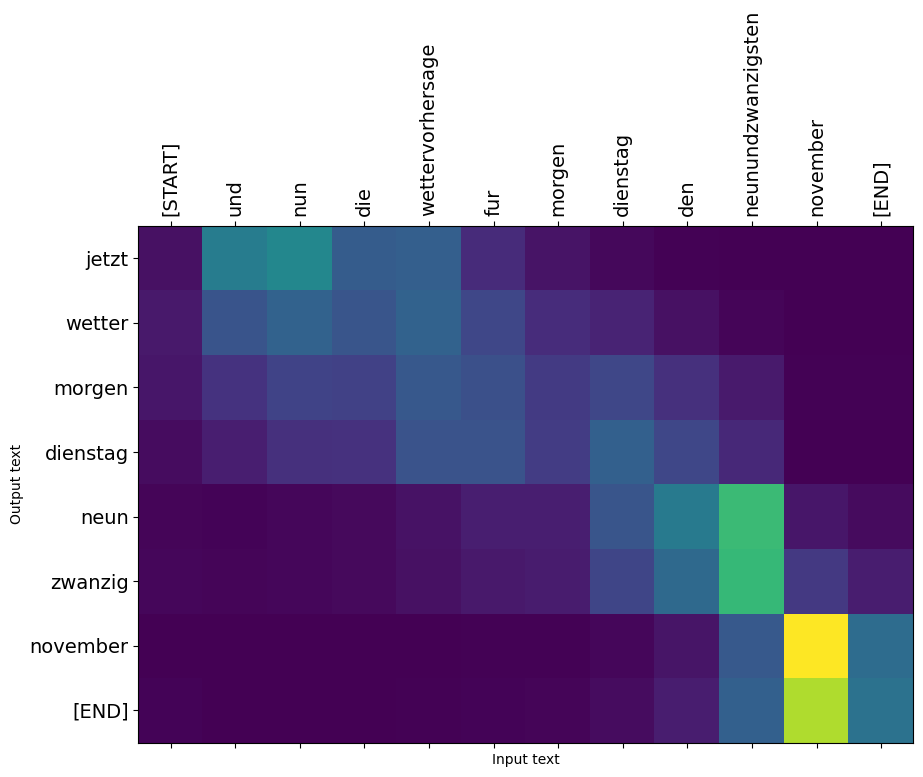

In [ ]:
model.plot_attention('und nun die wettervorhersage für morgen dienstag den neunundzwanzigsten november')

In [ ]:
input:
'und nun die wettervorhersage für morgen dienstag den neunundzwanzigsten november'
and now the weather forecast for tomorrow, Tuesday November 29th
observed:
'jetzt wetter morgen dienstag neun zwanzig november '
now weather tomorrow Tuesday nine twenty November
actual:
'jetzt wetter voraus informieren morgen dienstag neun zwanzig november'
now inform weather forecast tomorrow Tuesday nine twenty November

##try 2

In [ ]:
model1 = Translator(UNITS, context_text_processor, target_text_processor)

logits = model1((ex_context_tok, ex_tar_in))

print(f'Context tokens, shape: (batch, s, units) {ex_context_tok.shape}')
print(f'Target tokens, shape: (batch, t) {ex_tar_in.shape}')
print(f'logits, shape: (batch, t, target_vocabulary_size) {logits.shape}')

Context tokens, shape: (batch, s, units) (64, 38)
Target tokens, shape: (batch, t) (64, 21)
logits, shape: (batch, t, target_vocabulary_size) (64, 21, 1006)


In [ ]:
model1.compile(optimizer='adam',
              loss=masked_loss,
              metrics=[masked_acc, masked_loss])

In [ ]:
history1 = model1.fit(
    train_ds.repeat(),
    epochs=100,
    steps_per_epoch = 100,
    validation_data=val_ds,
    validation_steps = 20,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=10)])

Epoch 1/100
100/100 [==============================] - 85s 699ms/step - loss: 4.2495 - masked_acc: 0.2187 - masked_loss: 4.2488 - val_loss: 3.5203 - val_masked_acc: 0.2948 - val_masked_loss: 3.5203
Epoch 2/100
100/100 [==============================] - 61s 613ms/step - loss: 3.0295 - masked_acc: 0.3697 - masked_loss: 3.0295 - val_loss: 3.0660 - val_masked_acc: 0.3801 - val_masked_loss: 3.0660
Epoch 3/100
100/100 [==============================] - 59s 592ms/step - loss: 2.5028 - masked_acc: 0.4457 - masked_loss: 2.5029 - val_loss: 2.8237 - val_masked_acc: 0.4238 - val_masked_loss: 2.8237
Epoch 4/100
100/100 [==============================] - 61s 610ms/step - loss: 2.1342 - masked_acc: 0.5046 - masked_loss: 2.1343 - val_loss: 2.7774 - val_masked_acc: 0.4328 - val_masked_loss: 2.7774
Epoch 5/100
100/100 [==============================] - 59s 592ms/step - loss: 1.8773 - masked_acc: 0.5422 - masked_loss: 1.8773 - val_loss: 2.8366 - val_masked_acc: 0.4283 - val_masked_loss: 2.8366
Epoch 6/10

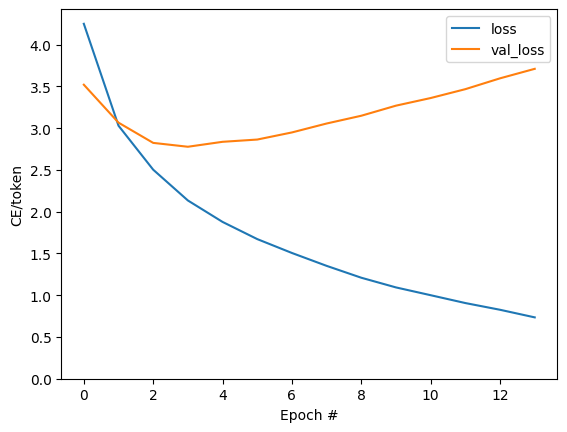

In [ ]:
plt.plot(history1.history['loss'], label='loss')
plt.plot(history1.history['val_loss'], label='val_loss')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('CE/token')
plt.legend()

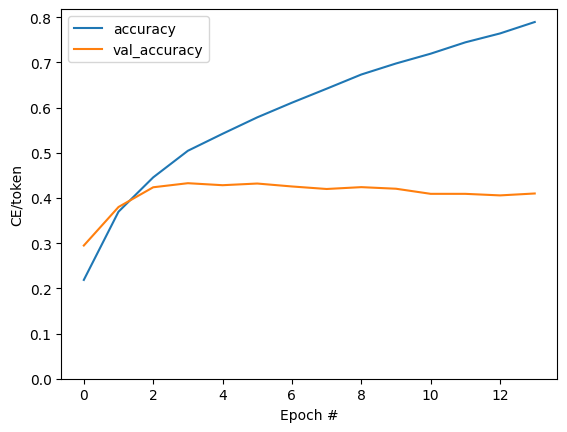

In [ ]:
plt.plot(history1.history['masked_acc'], label='accuracy')
plt.plot(history1.history['val_masked_acc'], label='val_accuracy')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('CE/token')
plt.legend()

In [ ]:
#@title
@Translator.add_method
def translate(self,
              texts, *,
              max_length=50,
              temperature=0.0):
  # Process the input texts
  context = self.encoder.convert_input(texts)
  batch_size = tf.shape(texts)[0]

  # Setup the loop inputs
  tokens = []
  attention_weights = []
  next_token, done, state = self.decoder.get_initial_state(context)

  for _ in range(max_length):
    # Generate the next token
    next_token, done, state = self.decoder.get_next_token(
        context, next_token, done,  state, temperature)

    # Collect the generated tokens
    tokens.append(next_token)
    attention_weights.append(self.decoder.last_attention_weights)

    if tf.executing_eagerly() and tf.reduce_all(done):
      break

  # Stack the lists of tokens and attention weights.
  tokens = tf.concat(tokens, axis=-1)   # t*[(batch 1)] -> (batch, t)
  self.last_attention_weights = tf.concat(attention_weights, axis=1)  # t*[(batch 1 s)] -> (batch, t s)

  result = self.decoder.tokens_to_text(tokens)
  return result

In [ ]:
result = model.translate(['am tag fünfzehn grad auf rügen und fünfundzwanzig grad am oberrhein'])
result[0].numpy().decode()

'morgen fuenfzehn grad ruegen fuenf zwanzig grad '

In [ ]:
Input:
During the day fifteen degrees on Rügen and twenty-five degrees on the Upper Rhine
am tag fünfzehn grad auf rügen und fünfundzwanzig grad am oberrhein

Observed:
model: morgen fuenfzehn grad ruegen fuenf zwanzig grad
model1: morgen fuenfzehn grad ruegen fuenf zwanzig grad
Tomorrow fifteen degrees ruegen five twenty

Actual:
tag fuenfzehn grad ruegen region fuenf zwanzig fluss
day fifteen degrees ruegen region five twenty river

In [ ]:
from nltk.translate.bleu_score import sentence_bleu

def calculate_bleu(reference, candidate):
    return sentence_bleu([reference], candidate)

reference = ["morgen", "fuenfzehn", "grad", "ruegen", "fuenf", "zwanzig", "grad"]
candidate = ["tag","fuenfzehn", "grad", "ruegen", "region", "fuenf", "zwanzig", "fluss"]
bleu_score = calculate_bleu(reference, candidate)
print("BLEU Score:", bleu_score)

BLEU Score: 5.614021910443866e-78


/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


# Character-level recurrent sequence-to-sequence model

**Author:** [fchollet](https://twitter.com/fchollet)<br>
**Date created:** 2017/09/29<br>
**Last modified:** 2020/04/26<br>
**Description:** Character-level recurrent sequence-to-sequence model.

## Introduction

This example demonstrates how to implement a basic character-level
recurrent sequence-to-sequence model. We apply it to translating
short English sentences into short French sentences,
character-by-character. Note that it is fairly unusual to
do character-level machine translation, as word-level
models are more common in this domain.

**Summary of the algorithm**

- We start with input sequences from a domain (e.g. English sentences)
    and corresponding target sequences from another domain
    (e.g. French sentences).
- An encoder LSTM turns input sequences to 2 state vectors
    (we keep the last LSTM state and discard the outputs).
- A decoder LSTM is trained to turn the target sequences into
    the same sequence but offset by one timestep in the future,
    a training process called "teacher forcing" in this context.
    It uses as initial state the state vectors from the encoder.
    Effectively, the decoder learns to generate `targets[t+1...]`
    given `targets[...t]`, conditioned on the input sequence.
- In inference mode, when we want to decode unknown input sequences, we:
    - Encode the input sequence into state vectors
    - Start with a target sequence of size 1
        (just the start-of-sequence character)
    - Feed the state vectors and 1-char target sequence
        to the decoder to produce predictions for the next character
    - Sample the next character using these predictions
        (we simply use argmax).
    - Append the sampled character to the target sequence
    - Repeat until we generate the end-of-sequence character or we
        hit the character limit.


## Setup


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras


## Download the data


## Configuration


In [ ]:
batch_size = 64  # Batch size for training.
epochs = 100  # Number of epochs to train for.
latent_dim = 256  # Latent dimensionality of the encoding space.
num_samples = 10000  # Number of samples to train on.
# Path to the data txt file on disk.
# data_path = "fra.txt"


## Prepare the data


In [ ]:
# Vectorize the data.
input_texts = []
target_texts = []
input_characters = set()
target_characters = set()

In [ ]:
from pathlib import Path

def load_data(file_path):
    # Use the Path class to create a Path object
    path = Path(file_path)

    # Open the file and read its content
    with path.open(mode='r', encoding='utf-8') as file:
        file_content = file.read()

    lines = file_content.splitlines()
    lines = np.array([i for i in lines])

    return lines

# Provide the correct file path
context = load_data("/content/phoenix_sentences_train_lower.txt")
target = load_data("/content/phoenix_glosses_train_lower.txt")

for i in range(len(target)):
  target[i] = "\t" + target[i] + "\n"

In [ ]:
input_texts = context.tolist()
target_texts = target.tolist()

In [ ]:
for input_text in input_texts:
    for char in input_text:
        if char not in input_characters:
            input_characters.add(char)
for target_text in target_texts:
    for char in target_text:
        if char not in target_characters:
            target_characters.add(char)

In [ ]:
input_characters = sorted(list(input_characters))
target_characters = sorted(list(target_characters))
num_encoder_tokens = len(input_characters)
num_decoder_tokens = len(target_characters)
max_encoder_seq_length = max([len(txt) for txt in input_texts])
max_decoder_seq_length = max([len(txt) for txt in target_texts])

print("Number of samples:", len(input_texts))
print("Number of unique input tokens:", num_encoder_tokens)
print("Number of unique output tokens:", num_decoder_tokens)
print("Max sequence length for inputs:", max_encoder_seq_length)
print("Max sequence length for outputs:", max_decoder_seq_length)

input_token_index = dict([(char, i) for i, char in enumerate(input_characters)])
target_token_index = dict([(char, i) for i, char in enumerate(target_characters)])

encoder_input_data = np.zeros(
    (len(input_texts), max_encoder_seq_length, num_encoder_tokens), dtype="float32"
)
decoder_input_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens), dtype="float32"
)
decoder_target_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens), dtype="float32"
)

for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
    for t, char in enumerate(input_text):
        encoder_input_data[i, t, input_token_index[char]] = 1.0
    encoder_input_data[i, t + 1 :, input_token_index[" "]] = 1.0
    for t, char in enumerate(target_text):
        # decoder_target_data is ahead of decoder_input_data by one timestep
        decoder_input_data[i, t, target_token_index[char]] = 1.0
        if t > 0:
            # decoder_target_data will be ahead by one timestep
            # and will not include the start character.
            decoder_target_data[i, t - 1, target_token_index[char]] = 1.0
    decoder_input_data[i, t + 1 :, target_token_index[" "]] = 1.0
    decoder_target_data[i, t:, target_token_index[" "]] = 1.0


Number of samples: 7096
Number of unique input tokens: 31
Number of unique output tokens: 33
Max sequence length for inputs: 300
Max sequence length for outputs: 207


## Build the model


In [ ]:
# Define an input sequence and process it.
encoder_inputs = keras.Input(shape=(None, num_encoder_tokens))
encoder = keras.layers.LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)

# We discard `encoder_outputs` and only keep the states.
encoder_states = [state_h, state_c]

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = keras.Input(shape=(None, num_decoder_tokens))

# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the
# return states in the training model, but we will use them in inference.
decoder_lstm = keras.layers.LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)
decoder_dense = keras.layers.Dense(num_decoder_tokens, activation="softmax")
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = keras.Model([encoder_inputs, decoder_inputs], decoder_outputs)


## Train the model


In [ ]:
model.compile(
    optimizer="rmsprop", loss="categorical_crossentropy", metrics=["accuracy"]
)
model.fit(
    [encoder_input_data, decoder_input_data],
    decoder_target_data,
    batch_size=batch_size,
    epochs=epochs,
    validation_split=0.2,
)
# Save model
model.save("s2s")


Epoch 1/100
89/89 [==============================] - 13s 55ms/step - loss: 1.0017 - accuracy: 0.7692 - val_loss: 0.7708 - val_accuracy: 0.7801
Epoch 2/100
89/89 [==============================] - 4s 42ms/step - loss: 0.7897 - accuracy: 0.7766 - val_loss: 0.7339 - val_accuracy: 0.7858
Epoch 3/100
89/89 [==============================] - 4s 42ms/step - loss: 0.7447 - accuracy: 0.7821 - val_loss: 0.7116 - val_accuracy: 0.7986
Epoch 4/100
89/89 [==============================] - 4s 42ms/step - loss: 0.7248 - accuracy: 0.7973 - val_loss: 0.6634 - val_accuracy: 0.8108
Epoch 5/100
89/89 [==============================] - 4s 45ms/step - loss: 0.6735 - accuracy: 0.8079 - val_loss: 0.6596 - val_accuracy: 0.8117
Epoch 6/100
89/89 [==============================] - 4s 44ms/step - loss: 0.6264 - accuracy: 0.8178 - val_loss: 0.5622 - val_accuracy: 0.8324
Epoch 7/100
89/89 [==============================] - 4s 42ms/step - loss: 0.5588 - accuracy: 0.8339 - val_loss: 0.5205 - val_accuracy: 0.8439
Epoch

## Run inference (sampling)

1. encode input and retrieve initial decoder state
2. run one step of decoder with this initial state
and a "start of sequence" token as target.
Output will be the next target token.
3. Repeat with the current target token and current states


In [ ]:
# Define sampling models
# Restore the model and construct the encoder and decoder.
model = keras.models.load_model("s2s")

encoder_inputs = model.input[0]  # input_1
encoder_outputs, state_h_enc, state_c_enc = model.layers[2].output  # lstm_1
encoder_states = [state_h_enc, state_c_enc]
encoder_model = keras.Model(encoder_inputs, encoder_states)

decoder_inputs = model.input[1]  # input_2
decoder_state_input_h = keras.Input(shape=(latent_dim,))
decoder_state_input_c = keras.Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_lstm = model.layers[3]
decoder_outputs, state_h_dec, state_c_dec = decoder_lstm(
    decoder_inputs, initial_state=decoder_states_inputs
)
decoder_states = [state_h_dec, state_c_dec]
decoder_dense = model.layers[4]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = keras.Model(
    [decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states
)

# Reverse-lookup token index to decode sequences back to
# something readable.
reverse_input_char_index = dict((i, char) for char, i in input_token_index.items())
reverse_target_char_index = dict((i, char) for char, i in target_token_index.items())


def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0, target_token_index["\t"]] = 1.0

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ""
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += sampled_char

        # Exit condition: either hit max length
        # or find stop character.
        if sampled_char == "\n" or len(decoded_sentence) > max_decoder_seq_length:
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.0

        # Update states
        states_value = [h, c]
    return decoded_sentence



You can now generate decoded sentences as such:


In [ ]:
for seq_index in range(20):
    # Take one sequence (part of the training set)
    # for trying out decoding.
    input_seq = encoder_input_data[seq_index : seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print("-")
    print("Input sentence:", input_texts[seq_index])
    print("Decoded sentence:", decoded_sentence)


1/1 [==============================] - 0s 22ms/step
-
Input sentence: und nun die wettervorhersage für morgen donnerstag den zwölften august
Decoded sentence: nord schwach maessig wehen

1/1 [==============================] - 0s 19ms/step
-
Input sentence: mancherorts regnet es auch länger und ergiebig auch lokale überschwemmungen sind wieder möglich
Decoded sentence: nord schwach maessig wehen

1/1 [==============================] - 0s 19ms/step
-
Input sentence: im nordwesten bleibt es heute nacht meist trocken sonst muss mit teilweise kräftigen schauern gerechnet werden örtlich mit blitz und donner
Decoded sentence: nord schwach maessig wehen

1/1 [==============================] - 0s 19ms/step
-
Input sentence: auch am tag gibt es verbreitet zum teil kräftige schauer oder gewitter und in manchen regionen fallen ergiebige regenmengen
Decoded sentence: nord schwach maessig wehen

1/1 [==============================] - 0s 24ms/step
-
Input sentence: größere wolkenlücken finden sich vo

#OpenNMT


In [ ]:
# Install OpenNMT
!pip install OpenNMT-tf

# Create a data directory
!mkdir -p data

# Prepare the data
# Assuming you have parallel German-Glosses data in the files "source_de.txt" and "target_de.txt"
# Make sure to replace this with your actual data

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.0/162.0 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.8/36.8 MB 37.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.0/17.0 MB 43.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.7/119.7 kB 13.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 612.1/612.1 kB 54.0 MB/s eta 0:00:00


In [ ]:
# Tokenize source and target text
!onmt-tokenize-text --tokenizer OpenNMTTokenizer --mode aggressive < data/source_de.txt > data/source_tokenized_de.txt
!onmt-tokenize-text --tokenizer OpenNMTTokenizer --mode aggressive < data/target_de.txt > data/target_tokenized_de.txt

# Create vocabularies
!onmt-build-vocab --size 50000 --save_vocab data/source_vocab.txt data/source_tokenized_de.txt
!onmt-build-vocab --size 50000 --save_vocab data/target_vocab.txt data/target_tokenized_de.txt

2023-11-15 07:27:06.745451: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-15 07:27:06.745532: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-15 07:27:06.745591: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-15 07:27:06.787891: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-15 07:27:10.116094: W tensorflow/compiler/

In [ ]:
!onmt-tokenize-text --tokenizer OpenNMTTokenizer --mode aggressive --source_words_vocabulary data/source_vocab.txt --target_words_vocabulary data/target_vocab.txt < data/source_de.txt > data/source_tokenized_de.txt
!onmt-tokenize-text --tokenizer OpenNMTTokenizer --mode aggressive --source_words_vocabulary data/source_vocab.txt --target_words_vocabulary data/target_vocab.txt < data/target_de.txt > data/target_tokenized_de.txt

2023-11-15 07:28:03.091886: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-15 07:28:03.091960: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-15 07:28:03.092002: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-15 07:28:03.102591: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-15 07:28:05.047903: W tensorflow/compiler/

In [ ]:
# Create a config.yaml file
config_content = """
model_dir: run
data:
  train_features_file: data/source_de.txt
  train_labels_file: data/target_de.txt
  eval_features_file: data/source_de.txt
  eval_labels_file: data/target_de.txt
  source_words_vocabulary: data/source_vocab.txt
  target_words_vocabulary: data/target_vocab.txt
train:
  save_checkpoints_steps: 1000
  batch_size: 32
  maximum_features_length: 50
  maximum_labels_length: 50
"""


In [ ]:
import os
os.chdir("/content/data")

In [ ]:
with open("data/config.yaml", "w") as config_file:
    config_file.write(config_content)

# Train the model
!onmt-main train --model_type Transformer --config data/config.yaml --auto_config --num_gpus 1

2023-11-15 07:28:48.603877: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-15 07:28:48.603965: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-15 07:28:48.604004: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-15 07:28:48.613945: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-15 07:28:49.969703: W tensorflow/compiler/

In [ ]:
onmt-main train --model_type Transformer --config path/to/your/config.yaml --auto_config --num_gpus 1


SyntaxError: ignored

In [ ]:
# Translate using the trained model
!onmt-main infer --model_dir run --auto_config --features_file data/source_de.txt --predictions_file data/output_de.txt
age: onmt-main [-h] [-v] --config CONFIG [CONFIG ...] [--model_dir MODEL_DIR] [--auto_config]                 [--model_type {GPT2Small,ListenAttendSpell,LstmCnnCrfTagger,LuongAttention,NMTBigV1,NMTMediumV1,NMTSmallV1,ScalingNmtEnDe,ScalingNmtEnFr,Transformer,TransformerBase,TransformerBaseRelative,TransformerBaseSharedEmbeddings,TransformerBig,TransformerBigRelative,TransformerBigSharedEmbeddings,TransformerRelative,TransformerTiny}]                 [--model MODEL] [--run_dir RUN_DIR] [--data_dir DATA_DIR]                 [--checkpoint_path CHECKPOINT_PATH]                 [--log_level {CRITICAL,ERROR,WARNING,INFO,DEBUG,NOTSET}] [--seed SEED]                 [--gpu_allow_growth]                 [--intra_op_parallelism_threads INTRA_OP_PARALLELISM_THREADS]                 [--inter_op_parallelism_threads INTER_OP_PARALLELISM_THREADS] [--mixed_precision]                 [--jit_compile] [--eager_execution]                 {train,eval,infer,export,score,average_checkpoints,update_vocab} ...onmt-main: error: the following arguments are required: --config[6]11s#%20Translate%20using%20the%20trained%20model!onmt-main%20infer%20--model_dir%20run%20--auto_config%20--features_file%20data/source_de.txt%20--predictions_file%20data/output_de.txtoutput2023-11-14%2014:24:08.288256:%20E%20tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342]%20Unable%20to%20register%20cuDNN%20factory:%20Attempting%20to%20register%20factory%20for%20plugin%20cuDNN%20when%20one%20has%20already%20been%20registered2023-11-14%2014:24:08.288353:%20E%20tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609]%20Unable%20to%20register%20cuFFT%20factory:%20Attempting%20to%20register%20factory%20for%20plugin%20cuFFT%20when%20one%20has%20already%20been%20registered2023-11-14%2014:24:08.288407:%20E%20tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518]%20Unable%20to%20register%20cuBLAS%20factory:%20Attempting%20to%20register%20factory%20for%20plugin%20cuBLAS%20when%20one%20has%20already%20been%20registered2023-11-14%2014:24:08.308239:%20I%20tensorflow/core/platform/cpu_feature_guard.cc:182]%20This%20TensorFlow%20binary%20is%20optimized%20to%20use%20available%20CPU%20instructions%20in%20performance-critical%20operations.To%20enable%20the%20following%20instructions:%20AVX2%20FMA,%20in%20other%20operations,%20rebuild%20TensorFlow%20with%20the%20appropriate%20compiler%20flags.2023-11-14%2014:24:11.080840:%20W%20tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38]%20TF-TRT%20Warning:%20Could%20not%20find%20TensorRT/usr/local/lib/python3.10/dist-packages/opennmt/version.py:23:%20UserWarning:%20OpenNMT-tf%20supports%20TensorFlow%20versions%202.6.0%20(included)%20to%202.14.0%20(excluded),%20but%20you%20have%20TensorFlow%202.14.0%20installed.%20Some%20features%20might%20not%20work%20properly.%20%20warnings.warn(/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23:%20UserWarning:%20TensorFlow%20Addons%20(TFA)%20has%20ended%20development%20and%20introduction%20of%20new%20features.TFA%20has%20entered%20a%20minimal%20maintenance%20and%20release%20mode%20until%20a%20planned%20end%20of%20life%20in%20May%202024.Please%20modify%20downstream%20libraries%20to%20take%20dependencies%20from%20other%20repositories%20in%20our%20TensorFlow%20community%20(e.g.%20Keras,%20Keras-CV,%20and%20Keras-NLP).%20For%20more%20information%20see:%20https://github.com/tensorflow/addons/issues/2807%20%20%20warnings.warn(/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/ensure_tf_install.py:53:%20UserWarning:%20Tensorflow%20Addons%20supports%20using%20Python%20ops%20for%20all%20Tensorflow%20versions%20above%20or%20equal%20to%202.11.0%20and%20strictly%20below%202.14.0%20(nightly%20versions%20are%20not%20supported).%20%20The%20versions%20of%20TensorFlow%20you%20are%20currently%20using%20is%202.14.0%20and%20is%20not%20supported.%20Some%20things%20might%20work,%20some%20things%20might%20not.If%20you%20were%20to%20encounter%20a%20bug,%20do%20not%20file%20an%20issue.If%20you%20want%20to%20make%20sure%20you're%20using%20a%20tested%20and%20supported%20configuration,%20either%20change%20the%20TensorFlow%20version%20or%20the%20TensorFlow%20Addons's%20version.%20You%20can%20find%20the%20compatibility%20matrix%20in%20TensorFlow%20Addon's%20readme:https://github.com/tensorflow/addons%20%20warnings.warn(usage:%20onmt-main%20[-h]%20[-v]%20--config%20CONFIG%20[CONFIG%20...]%20[--model_dir%20MODEL_DIR]%20[--auto_config]%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20[--model_type%20{GPT2Small,ListenAttendSpell,LstmCnnCrfTagger,LuongAttention,NMTBigV1,NMTMediumV1,NMTSmallV1,ScalingNmtEnDe,ScalingNmtEnFr,Transformer,TransformerBase,TransformerBaseRelative,TransformerBaseSharedEmbeddings,TransformerBig,TransformerBigRelative,TransformerBigSharedEmbeddings,TransformerRelative,TransformerTiny}]%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20[--model%20MODEL]%20[--run_dir%20RUN_DIR]%20[--data_dir%20DATA_DIR]%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20[--checkpoint_path%20CHECKPOINT_PATH]%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20[--log_level%20{CRITICAL,ERROR,WARNING,INFO,DEBUG,NOTSET}]%20[--seed%20SEED]%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20[--gpu_allow_growth]%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20[--intra_op_parallelism_threads%20INTRA_OP_PARALLELISM_THREADS]%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20[--inter_op_parallelism_threads%20INTER_OP_PARALLELISM_THREADS]%20[--mixed_precision]%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20[--jit_compile]%20[--eager_execution]%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20{train,eval,infer,export,score,average_checkpoints,update_vocab}%20...onmt-main:%20error:%20the%20following%20arguments%20are%20required:%20--config

2023-11-14 14:24:08.288256: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-14 14:24:08.288353: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-14 14:24:08.288407: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-14 14:24:08.308239: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-14 14:24:11.080840: W tensorflow/compiler/

#AAAAAAAAAAAAAAAAAAAAA

In [ ]:
!pip install torchtext==0.4.0

In [ ]:
!pip install OpenNMT-py

In [ ]:
!onmt_build_vocab -config Data/config.yml

2023-11-17 11:08:18.036291: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-17 11:08:18.036352: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-17 11:08:18.036393: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-17 11:08:18.044669: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-17 11:08:19.263613: W tensorflow/c

In [ ]:
!onmt_train -config Data/config.yml

2023-11-17 11:08:44.605749: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-17 11:08:44.605809: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-17 11:08:44.605849: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-17 11:08:44.613540: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-17 11:08:45.796215: W tensorflow/c

In [ ]:
!python /usr/local/lib/python3.10/dist-packages/onmt/bin/train.py \
    -config Data/config.yml \
    -src_vocab Data/run/example.vocab.src \
    -tgt_vocab Data/run/example.vocab.tgt \
    -overwrite False \
    -save_model model \
    -save_checkpoint_steps 5000 \
    -train_steps 10000 \
    -valid_steps 5000 \
    -encoder_type transformer \
    -decoder_type transformer \
    -enc_hid_size 512 \
    -dec_hid_size 512 \
    -heads 8 \
    -layers 6 \
    -rnn_size 512 \
    -word_vec_size 512 \
    -transformer_ff 2048 \
    -dropout 0.1 \
    -label_smoothing 0.1 \
    -gpu_ranks 0 \
    -world_size 1


2023-11-17 10:46:10.854567: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-17 10:46:10.854627: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-17 10:46:10.854662: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-17 10:46:12.072017: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
[2023-11-17 10:46:14,612 INFO] Missing transforms field for corpus_1 data, set to default: [].
[2023-11-17 10:46:14,612 WARNING] Corpus corpus_1's weight should be given. We default it to 1 for you.
[2023-11-17 10:46:14,612 INFO] Missing 

In [ ]:
!onmt_translate -model /content/model_step_10000.pt -src Data/src-test.txt -output Data/pred_10000.txt -gpu 0 -verbose

Streaming output truncated to the last 5000 lines.
PRED 4756: 
PRED SCORE: -0.4832

[2023-11-17 10:44:44,091 INFO] 
SENT 4757: ['<unk>', '<unk>', '<unk>']
PRED 4757: 
PRED SCORE: -0.4832

[2023-11-17 10:44:44,091 INFO] 
SENT 4758: ['dann', 'habe', 'ich', 'noch', 'eine', 'sache', 'dazu', 'zu', 'sagen']
PRED 4758: 
PRED SCORE: -0.4832

[2023-11-17 10:44:44,092 INFO] 
SENT 4759: ['ich', 'habe', 'eine', '<unk>', 'sache', 'im', '<unk>', 'gesehen', 'die', 'dort', '<unk>', 'wurde', 'und', 'der', 'ich', '<unk>']
PRED 4759: 
PRED SCORE: -0.4832

[2023-11-17 10:44:44,092 INFO] 
SENT 4760: ['es', 'ging', '<unk>', 'dass', 'es', 'in', 'der', '<unk>', 'immer', 'wieder', '<unk>', 'um', 'die', 'höhe', 'des', '<unk>', 'gibt']
PRED 4760: 
PRED SCORE: -0.4832

[2023-11-17 10:44:44,093 INFO] 
SENT 4761: ['eine', '<unk>', 'aber', 'er', '<unk>', 'nicht', 'welche']
PRED 4761: 
PRED SCORE: -0.4832

[2023-11-17 10:44:44,093 INFO] 
SENT 4762: ['in', 'der', '<unk>', 'also', 'bei', 'den', '<unk>', 'und', 'den', '

In [ ]:
!touch bleu.py

In [ ]:
!python bleu.py 1 /content/Data/tgt-test.txt  /content/Data/pred_10000.txt
!python bleu.py 2 /content/Data/tgt-test.txt  /content/Data/pred_10000.txt
!python bleu.py 3 /content/Data/tgt-test.txt  /content/Data/pred_10000.txt
!python bleu.py 4 /content/Data/tgt-test.txt  /content/Data/pred_10000.txt


0
0
0
0


In [ ]:
!head /content/Data/pred_10000.txt

regen schnee regen alpen nacht nord region schauer sonst region klar
donnerstag regen nord kommen sonne wolke dann freitag auch freitag
nord kommen tief kommen kommen regen schnee
samstag sonntag sonntag sonntag sonntag auch samstag sinken bis elf grad
deutsch land morgen hoch kommen wolke
sonntag sonntag sonne wolke wolke teil gewitter
schauer gewitter
in-kommend in-kommend winter bleiben schnee
wochenende mehr kalt
morgen bleiben ruhig sonne wolke


In [ ]:
!pip install -q googletrans==4.0.0-rc1

In [ ]:
from googletrans import Translator
# Create a Translator object
translator = Translator()
with open("/content/Data/pred_10000.txt", 'r', encoding='utf-8') as file:
        pred = file.readlines()
with open("/content/Data/tgt-test.txt", 'r', encoding='utf-8') as file:
        target = file.readlines()
for i in range(20):
        pred_text = translator.translate(pred[i], src='de', dest='en').text
        print(pred_text,"predicted text".upper())
        tar_text =  translator.translate(target[i], src='de', dest='en').text
        print(tar_text,"Target text".upper())

Rain snow rain alpine night north region shower otherwise clear region PREDICTED TEXT
rain snow region disappear north rain can see region star TARGET TEXT
Thursday rain north come sun cloud then on Friday also Friday PREDICTED TEXT
Thursday northwest rain region sun cloud changeable then on Friday TARGET TEXT
North come deep come in the rain snow PREDICTED TEXT
Craumineted from tomorrow early mostly snow snowing cold rain TARGET TEXT
Saturday Sunday Sunday Sunday also Saturday to be eleven degrees PREDICTED TEXT
Weekend sun Saturday beautiful temperature up to seventeen degrees region TARGET TEXT
germany tomorrow. PREDICTED TEXT
Germany tomorrow high pressure come TARGET TEXT
Sunday Sunday sun cloud cloud part thunderstorms PREDICTED TEXT
Sunday of the next northwest cloud sun cloud thunderstorm rain TARGET TEXT
Schauer thunderstorms PREDICTED TEXT
Probably shiver thunderstorms strong TARGET TEXT
Incoming in the way, snow remain PREDICTED TEXT
IM grading remain cold enormously snow TA

#yt

In [ ]:
!cat /content/aslg.train.gloss.asl > tgt-train.txt

In [ ]:
import pandas as pd

# Load the CSV file into a pandas DataFrame
csv_file_path = '/content/Hindi_English_Truncated_Corpus.csv'  # Replace with the path to your CSV file
df = pd.read_csv(csv_file_path)

# Determine the column names
column_names = df.columns.tolist()

# Write the data from each column to separate text files
for column_name in column_names:
    column_data = df[column_name].astype(str).tolist()
    with open(f'{column_name}.txt', 'w', encoding='utf-8') as file:
        file.write('\n'.join(column_data))


In [ ]:
for i in range(1,100):
  if(23415%i == 0):
    print(i)

1
3
5
7
15
21
35


In [ ]:
def extract_top_sentences_with_index(english_file, hindi_file, output_english_file, output_hindi_file, length_range, max_sentences=1000):
    # Read English and Hindi files
    with open(english_file, 'r', encoding='utf-8') as english_file, open(hindi_file, 'r', encoding='utf-8') as hindi_file:
        english_sentences = english_file.readlines()
        hindi_sentences = hindi_file.readlines()

    # Filter sentences based on length
    filtered_indexes = [index for index, sentence in enumerate(english_sentences) if length_range[0] <= len(sentence.split()) <= length_range[1]]

    # Extract English and Hindi sentences with indexes
    filtered_english_sentences = [english_sentences[index].strip() for index in filtered_indexes]
    filtered_hindi_sentences = [hindi_sentences[index].strip() for index in filtered_indexes]

    # Write the filtered English sentences with indexes to the output file
    with open(output_english_file, 'w', encoding='utf-8') as english_output_file:
        for index, english_sentence in enumerate(filtered_english_sentences):
            english_output_file.write(f"{english_sentence}\n")

    # Write the filtered Hindi sentences with indexes to the output file
    with open(output_hindi_file, 'w', encoding='utf-8') as hindi_output_file:
        for index, hindi_sentence in enumerate(filtered_hindi_sentences):
            hindi_output_file.write(f"{hindi_sentence}\n")

if __name__ == "__main__":
    # English text file
    english_input_file = '/content/en_sent.txt'

    # Hindi text file
    hindi_input_file = '/content/hi_sent.txt'

    # Output files for English and Hindi sentences
    output_english_file = 'english.txt'
    output_hindi_file = 'hindi.txt'

    # Length range for sentences
    length_range = (5, 10)

    # Extract and write the top 1000 English and corresponding Hindi sentences with indexes
    extract_top_sentences_with_index(english_input_file, hindi_input_file, output_english_file, output_hindi_file, length_range, max_sentences=1000)



In [ ]:
import random

def split_data(src_file, tgt_file, src_train, src_test, src_val, tgt_train, tgt_test, tgt_val, train_percent=0.7, test_percent=0.15, val_percent=0.15):
    # Read source and target sentences
    with open(src_file, 'r', encoding='utf-8') as src_file:
        src_sentences = src_file.readlines()

    with open(tgt_file, 'r', encoding='utf-8') as tgt_file:
        tgt_sentences = tgt_file.readlines()

    # Check if the number of sentences in both files is the same
    if len(src_sentences) != len(tgt_sentences):
        print("Error: Number of sentences in source and target files do not match.")
        return

    total_sentences = len(src_sentences)
    indices = list(range(total_sentences))
    random.shuffle(indices)

    # Calculate the number of sentences for each split
    train_size = int(total_sentences * train_percent)
    test_size = int(total_sentences * test_percent)
    val_size = int(total_sentences * val_percent)

    # Split indices into train, test, and validation sets
    train_indices = indices[:train_size]
    test_indices = indices[train_size:train_size + test_size]
    val_indices = indices[train_size + test_size:]

    # Write source and target sets to separate files
    write_set(src_sentences, src_train, train_indices)
    write_set(src_sentences, src_test, test_indices)
    write_set(src_sentences, src_val, val_indices)

    write_set(tgt_sentences, tgt_train, train_indices)
    write_set(tgt_sentences, tgt_test, test_indices)
    write_set(tgt_sentences, tgt_val, val_indices)

def write_set(sentences, output_file, indices):
    with open(output_file, 'w', encoding='utf-8') as output_file:
        for index in indices:
            output_file.write(sentences[index])

if __name__ == "__main__":
    src_file_path = "/content/hindi.txt"
    tgt_file_path = "/content/english.txt"

    src_train_path = "src-train.txt"
    src_test_path = "src-test.txt"
    src_val_path = "src-val.txt"

    tgt_train_path = "tgt-train.txt"
    tgt_test_path = "tgt-test.txt"
    tgt_val_path = "tgt-val.txt"

    split_data(src_file_path, tgt_file_path, src_train_path, src_test_path, src_val_path, tgt_train_path, tgt_test_path, tgt_val_path)


##OpenNMT


In [ ]:
# Install OpenNMT
!pip install OpenNMT-py

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 257.3/257.3 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.8/36.8 MB 45.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.7/57.7 kB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.0/17.0 MB 92.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.7/119.7 kB 16.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 79.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.8/110.8 kB 13.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 63.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.7/227.7 kB 29.7 MB/s eta 0:00:00


### Build the model


In [ ]:
!onmt_build_vocab -config /content/Data/config.yml -n_sample 100000

2023-11-19 08:28:02.905658: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-19 08:28:02.905729: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-19 08:28:02.905772: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-19 08:28:02.917537: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-19 08:28:04.979200: W tensorflow/compiler/

### Train the model

In [ ]:
!onmt_train -config /content/Data/config.yml

2023-11-19 08:28:15.680352: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-19 08:28:15.680405: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-19 08:28:15.680448: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-19 08:28:15.688768: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-19 08:28:17.104640: W tensorflow/compiler/

### Evaluating the model


In [ ]:
!onmt_translate -model /content/Data/run/model_step_10000.pt -src /content/Data/src-test.txt -output /content/hin-eng-onmt.txt -gpu 0 -verbose

Streaming output truncated to the last 5000 lines.
PRED 8823: “ But the wind … ”
PRED SCORE: -0.4673

[2023-11-19 08:39:01,310 INFO] 
SENT 8824: ['परिवर्तन', 'एक', 'मानक', 'टेम्पलेट', 'में', 'सहेजा', 'नहीं', 'जा', 'सकता', 'है.']
PRED 8824: Cannot load changes into standard template
PRED SCORE: -0.3229

[2023-11-19 08:39:01,310 INFO] 
SENT 8825: ['इन', 'वस्तुओं', 'को', 'प्रयोग', 'करने', 'में', 'ज्यादा', 'मज़ेदार', 'लगता', 'है।']
PRED 8825: It's more interesting to use these objects,
PRED SCORE: -0.6735

[2023-11-19 08:39:01,310 INFO] 
SENT 8826: ['समूह', 'के', 'लिए', 'नया', 'प्रश्न', 'जोड़ें']
PRED 8826: Add new question for group
PRED SCORE: -0.0636

[2023-11-19 08:39:01,311 INFO] 
SENT 8827: ['पूरे', 'अमरीका', 'में।']
PRED 8827: in the United States across the United States
PRED SCORE: -0.3477

[2023-11-19 08:39:01,311 INFO] 
SENT 8828: ['नए', 'विंडोज़', 'पिछले', 'विंडो', 'खाका', 'का', 'उपयोग', 'करें']
PRED 8828: Use new windows last window
PRED SCORE: -0.2220

[2023-11-19 08:39:01,31

### BLEU Scores and Translations

In [ ]:
!touch bleu.py

In [ ]:
!python bleu.py 1 /content/Data/tgt-test.txt  /content/hin-eng-onmt.txt
!python bleu.py 2 /content/Data/tgt-test.txt  /content/hin-eng-onmt.txt
!python bleu.py 3 /content/Data/tgt-test.txt  /content/hin-eng-onmt.txt
!python bleu.py 4 /content/Data/tgt-test.txt  /content/hin-eng-onmt.txt


0.9418943424723365
0.9228918619284411
0.9050097347853664
0.8875022512809427


In [ ]:
!head /content/hin-eng-onmt.txt

date be not foregone .
result speak for mselves .
it should mean that everyone be give equal opportunity .
europe have do very great deal work in this field , which be to be welcome .
we simply have to build it stage by stage .
it be issue proportionality .
we be talk about rights , semus and freedom .
that attempt do not succeed , but it do represent precedent for that kind gar .
this green paper be important , see as it concern matter that need to be deal with .
mr audy ask follow question be you blind sufficient size ?
